# Tuberculosis Detection from Chest X-ray Images

Digital Image Processing – Final Project
Informatics – Institut Teknologi Kalimantan | Semester Genap 2024/2025

**Group 3 :**
- Raihan Fadhilah (11221062)
- Amrina Rossada (11221006)
- Rafli Pratama Yuliandi (11221090)
- Ince Iqbal Aulia Salam (11221016)


# 1. Introduction & Problem Statement
This project aims to detect signs of tuberculosis (TB) in chest X-ray images using classical digital image processing techniques. We implement a full image processing pipeline—from preprocessing to feature extraction and analysis—to highlight the effectiveness of each step.

### 1.1 Dataset Description
We use publicly available chest X-ray dataset:

[Tuberculosis (TB) Chest X-ray Database](https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset)

This dataset is a result of a collaboration between researchers from Qatar University, the University of Dhaka, and other institutions. Specifically, this dataset contains:

- 3500 Normal chest X-ray images.
- 700 publicly available chest X-ray images of patients with Tuberculosis (TB).

### 1.2 Technique Selection Justification
**Preprocessing**
- Grayscale
- Image resizing
- CLAHE
- Gaussian Blur

**Image Processing**
- Morphological cleaning
- Thresholding (Otsu)

**Feature Extraction**
- Lesion region area & lung shape
- GLCM-based texture descriptors
- Histogram statistics

## Preprocessing Pipeline

### Modules

In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, closing, disk
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import random
import seaborn as sns

#### Load .env

In [2]:
# load_dotenv()

### Preprocessing

#### Grayscale

In [3]:
def manual_rgb_to_grayscale(rgb_img):
    """
    Mengubah gambar RGB menjadi grayscale secara manual menggunakan formula luminansi.
    Asumsi gambar input adalah array NumPy dengan 3 channel (tinggi, lebar, 3).
    """
    if rgb_img is None or rgb_img.size == 0:
        raise ValueError("Gambar input kosong atau tidak valid.")
    if len(rgb_img.shape) < 3 or rgb_img.shape[2] < 3:
        # Gambar sudah grayscale atau memiliki kurang dari 3 channel
        return rgb_img
    
    # Formula umum untuk luminansi: Y = 0.299*R + 0.587*G + 0.114*B
    grayscale_img = np.dot(rgb_img[...,:3], [0.299, 0.587, 0.114])
    return grayscale_img.astype(np.uint8)

#### Image Resizing

In [4]:
def manual_resize_nearest_neighbor(img, new_width, new_height):
    """
    Mengubah ukuran gambar secara manual menggunakan metode nearest neighbor.
    Asumsi gambar input adalah array NumPy 2D (grayscale).
    """
    if img is None or img.size == 0:
        raise ValueError("Gambar input kosong atau tidak valid.")

    original_height, original_width = img.shape
    resized_img = np.zeros((new_height, new_width), dtype=img.dtype)

    # Hitung rasio skala untuk setiap dimensi
    x_ratio = float(original_width) / new_width
    y_ratio = float(original_height) / new_height

    # Iterasi melalui setiap piksel di gambar yang diubah ukurannya
    for i in range(new_height):
        for j in range(new_width):
            # Temukan piksel terdekat di gambar asli
            px = int(np.floor(j * x_ratio))
            py = int(np.floor(i * y_ratio))
            # Pastikan indeks tidak melebihi batas gambar asli
            px = min(px, original_width - 1)
            py = min(py, original_height - 1)
            resized_img[i, j] = img[py, px]
            
    return resized_img

#### CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [5]:
def manual_clahe_tile(tile, clip_limit, num_bins=256):
    """
    Menerapkan CLAHE pada satu tile gambar secara manual.
    """
    # Hitung histogram
    hist, _ = np.histogram(tile.flatten(), num_bins, [0, 256])
    
    # Hitung ambang batas kliping (clip threshold)
    if clip_limit > 0:
        clip_threshold = max(1, int(tile.size * clip_limit / num_bins))
    else:
        clip_threshold = tile.size 

    # Klip histogram dan redistribusi piksel yang berlebih
    total_excess = 0
    for i in range(num_bins):
        if hist[i] > clip_threshold:
            total_excess += hist[i] - clip_threshold
            hist[i] = clip_threshold
            
    # Redistribusi piksel yang berlebih secara merata
    redist_val = total_excess // num_bins
    hist += redist_val
    
    # Sisa redistribusi
    excess_rem = total_excess % num_bins
    hist[:excess_rem] += 1
    
    # Hitung Cumulative Distribution Function (CDF)
    cdf = hist.cumsum()
    
    # Normalisasi CDF untuk mendapatkan nilai piksel baru
    if cdf.max() == cdf.min():
        return np.zeros_like(cdf, dtype=np.uint8)
        
    cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    
    return cdf.astype('uint8')

def manual_clahe_interpolated(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Menerapkan CLAHE pada gambar secara manual dengan interpolasi bilinear.
    """
    if image is None or image.size == 0:
        raise ValueError("Gambar input kosong atau tidak valid.")

    img_h, img_w = image.shape
    tile_rows, tile_cols = tile_grid_size
    
    if tile_rows == 0 or tile_cols == 0:
        raise ValueError("tile_grid_size tidak boleh nol.")
        
    tile_h = img_h / tile_rows
    tile_w = img_w / tile_cols

    # Simpan LUT (Look-Up Table) untuk setiap tile
    luts = [[None for _ in range(tile_cols)] for _ in range(tile_rows)]
    for r in range(tile_rows):
        for c in range(tile_cols):
            # Tentukan batas tile
            r_start = int(r * tile_h)
            r_end = int((r + 1) * tile_h)
            c_start = int(c * tile_w)
            c_end = int((c + 1) * tile_w)
            
            # Ekstrak tile (Region of Interest)
            roi = image[r_start:r_end, c_start:c_end]
            if roi.size > 0:
                luts[r][c] = manual_clahe_tile(roi, clip_limit)

    # Lakukan interpolasi bilinear untuk setiap piksel
    output_image = np.zeros_like(image, dtype=np.float32)

    for r_pixel in range(img_h):
        for c_pixel in range(img_w):
            # Tentukan posisi piksel relatif terhadap grid tile
            r_norm = r_pixel / tile_h - 0.5
            c_norm = c_pixel / tile_w - 0.5

            # Dapatkan indeks tile terdekat (atas-kiri)
            r_idx = int(r_norm)
            c_idx = int(c_norm)
            
            # Hitung fraksi untuk interpolasi
            y_frac = r_norm - r_idx
            x_frac = c_norm - c_idx
            
            # Pastikan indeks dalam batas
            r_idx = max(0, min(r_idx, tile_rows - 1))
            c_idx = max(0, min(c_idx, tile_cols - 1))
            
            r_next_idx = min(r_idx + 1, tile_rows - 1)
            c_next_idx = min(c_idx + 1, tile_cols - 1)
            
            pixel_val = image[r_pixel, c_pixel]

            # Dapatkan LUT dari 4 tile yang mengelilingi piksel
            lut_tl = luts[r_idx][c_idx]      
            lut_tr = luts[r_idx][c_next_idx]  
            lut_bl = luts[r_next_idx][c_idx]  
            lut_br = luts[r_next_idx][c_next_idx] 

            # Pastikan LUT tidak None (jika tile kosong)
            val_tl = lut_tl[pixel_val] if lut_tl is not None else pixel_val
            val_tr = lut_tr[pixel_val] if lut_tr is not None else pixel_val
            val_bl = lut_bl[pixel_val] if lut_bl is not None else pixel_val
            val_br = lut_br[pixel_val] if lut_br is not None else pixel_val
            
            # Interpolasi horizontal
            top_interp = (1 - x_frac) * val_tl + x_frac * val_tr
            bottom_interp = (1 - x_frac) * val_bl + x_frac * val_br
            
            # Interpolasi vertikal
            final_val = (1 - y_frac) * top_interp + y_frac * bottom_interp
            
            output_image[r_pixel, c_pixel] = final_val

    return output_image.astype('uint8')

#### Gaussian Blur

In [6]:
def manual_gaussian_kernel(size, sigma=1.0):
    """
    Membuat kernel Gaussian 2D secara manual.
    """
    kernel_1d = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(kernel_1d, kernel_1d)
    
    # Menghitung nilai kernel menggunakan rumus Gaussian
    kernel_2d = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # Normalisasi agar total bobotnya 1
    kernel_2d = kernel_2d / np.sum(kernel_2d)
    
    return kernel_2d

def manual_gaussian_blur(image, kernel_size, sigma):
    """
    Menerapkan Gaussian Blur pada gambar secara manual melalui konvolusi.
    """
    kernel = manual_gaussian_kernel(kernel_size, sigma)
    k_h, k_w = kernel.shape
    
    # Padding citra untuk menangani tepi menggunakan mode 'reflect'
    pad_h = k_h // 2
    pad_w = k_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    
    # Inisialisasi citra output
    output_image = np.zeros_like(image, dtype=np.float32) # Ubah dtype ke float untuk perhitungan
    
    # Operasi konvolusi
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Ekstrak region of interest (ROI) yang akan dikonvolusi
            roi = padded_image[y:y + k_h, x:x + k_w]
            
            # Hitung nilai piksel baru
            output_image[y, x] = np.sum(roi * kernel)
            
    return output_image.astype(np.uint8)

In [7]:
def preprocess_image_manual(img_path):
    # Membaca gambar dalam format RGB (untuk konversi grayscale manual)
    img = cv2.imread(img_path) 
    if img is None:
        print(f"Warning: Could not read image at {img_path}")
        return None, None
        
    # Konversi ke grayscale secara manual
    img_grayscale = manual_rgb_to_grayscale(img) 
    
    # Mengubah ukuran gambar secara manual
    img_resized = manual_resize_nearest_neighbor(img_grayscale, 256, 256) 
    
    # Menerapkan CLAHE manual
    img_clahe = manual_clahe_interpolated(img_resized, clip_limit=2.0, tile_grid_size=(8, 8))

    # Menerapkan Gaussian Blur manual
    img_blur = manual_gaussian_blur(img_clahe, kernel_size=5, sigma=1.0)

    return img_blur, img_clahe

## Image Processing & Transformation

### Otsu Thresholding + Morphological Cleaning

In [8]:
def segment_mask(img):
    """
    Menerapkan Otsu thresholding dan operasi morfologi untuk segmentasi.
    """
    try:
        t = threshold_otsu(img)
        mask = img > t
        mask = remove_small_objects(mask, min_size=500)
        mask = closing(mask, disk(5))
        return mask
    except:
        # Mengembalikan None jika terjadi kesalahan (misalnya gambar kosong)
        return None

### Labeling & Region Properties

In [9]:
def extract_features(mask, img):
    """
    Mengekstrak fitur-fitur dari region yang tersegmentasi.
    """
    labeled = label(mask)
    regions = regionprops(labeled, intensity_image=img)
    if not regions:
        return None
    r = max(regions, key=lambda x: x.area) # Memilih region terbesar
    minr, minc, maxr, maxc = r.bbox
    cropped = img[minr:maxr, minc:maxc]
    
    # Mengubah ukuran gambar yang dipotong secara manual
    cropped = manual_resize_nearest_neighbor(cropped, 64, 64) 
    cropped = np.uint8(cropped / np.max(cropped) * 255) # Normalisasi ke 0-255

    # Menghitung GLCM
    glcm = graycomatrix(cropped, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return {
        'area': r.area,
        'perimeter': r.perimeter,
        'eccentricity': r.eccentricity,
        'mean_intensity': r.mean_intensity,
        'solidity': r.solidity,
        'glcm_contrast': graycoprops(glcm, 'contrast')[0, 0],
        'glcm_homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'glcm_energy': graycoprops(glcm, 'energy')[0, 0],
        'glcm_correlation': graycoprops(glcm, 'correlation')[0, 0],
    }

## Analysis & Feature Extraction

In [10]:
data_dir = '../data/TB_Chest_Radiography_Database/'
classes = ['Tuberculosis', 'Normal']
features = []

visual_samples = {
    cls: random.choice(os.listdir(os.path.join(data_dir, cls)))
    for cls in classes
}

for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    for fname in tqdm(os.listdir(class_dir)):
        path = os.path.join(class_dir, fname)        
        # Menggunakan pipeline preprocessing manual yang baru
        img_processed, clahe_img_manual = preprocess_image_manual(path)

        if fname == visual_samples[cls]:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            # Membaca gambar asli sebagai warna untuk menunjukkan konversi grayscale yang benar
            plt.imshow(cv2.imread(path), cmap='gray') 
            plt.title(f'{cls} - Original')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(clahe_img_manual, cmap='gray')
            plt.title('CLAHE')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(img_processed, cmap='gray')
            plt.title('Gaussian Blur')
            plt.axis('off')

            plt.suptitle(f'{cls} - Visualisasi Preprocessing', fontsize=14)
            plt.tight_layout()
            plt.show()


        if cls == 'Normal':
            feats = {
                'area': 0, 'perimeter': 0, 'eccentricity': 0,
                'mean_intensity': np.mean(img_processed),
                'glcm_contrast': 0, 'glcm_homogeneity': 0,
                'glcm_energy': 0, 'glcm_correlation': 0
            }
        else:
            mask = segment_mask(img_processed)
            if mask is None:
                continue
            # Menggunakan output dari pipeline preprocessing manual
            feats = extract_features(mask, img_processed)
            if feats is None:
                continue

        feats['label'] = cls
        features.append(feats)

df = pd.DataFrame(features)
df.to_csv('tb_features_glcm.csv', index=False)

  0%|          | 0/700 [00:00<?, ?it/s]

 13%|█▎        | 93/700 [02:45<15:47,  1.56s/it]

## Comparative Analysis

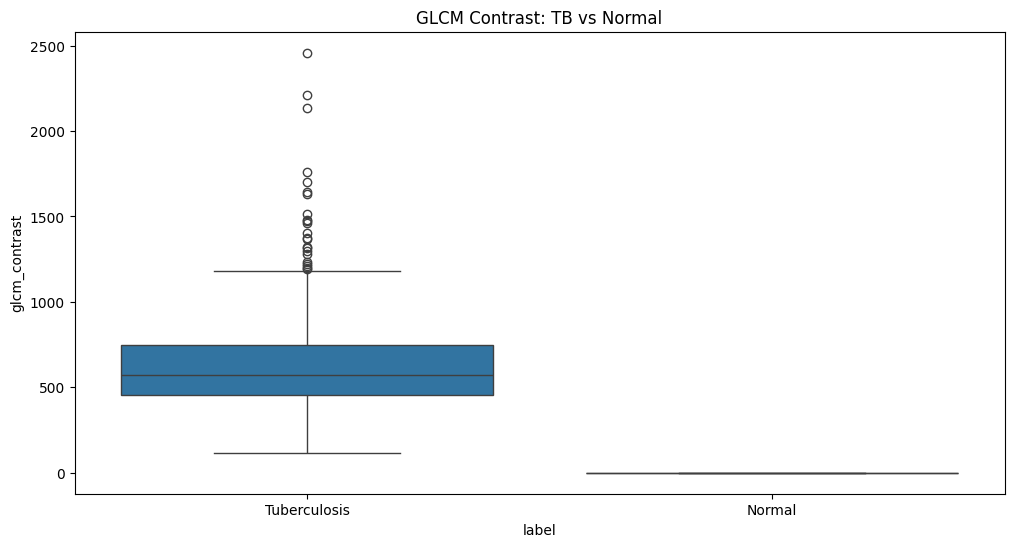

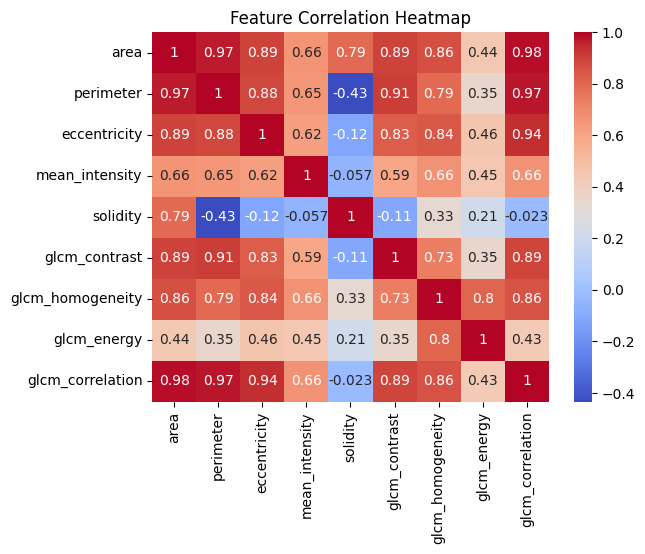

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='label', y='glcm_contrast')
plt.title("Kontras GLCM: TB vs Normal")
plt.show()

corr = df.drop(columns='label').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

## Conclusion

- CLAHE + Gaussian Blur preprocessing improved visibility of lung lesions.
- Otsu + morphological ops successfully isolated lung/lesion regions.
- GLCM features (e.g., contrast, correlation) were more discriminative than basic shape features.
- The dataset allows clear visual and quantitative differentiation between TB and Normal classes.

Future work: apply ML classifier (SVM/KNN) on features, or try full lung segmentation.
